# Notes

This code can perform the following tasks:


*   Tune a CNN to directly reconstruct PET images from Sinograms (find a set of hyperparameters)
*   Train a network with a given set of hyperparameters
*   Test the network and record MSE and SSIM values for each image tested
*   Visualize the data and test results
*   Plot training curves, metric histograms, example images

The code is organized into sections. The important sections that you can edit are:


> **User Parameters** - Edit important user parameters and decide what the code will do

> **Configuration Dicts: Supervisory** - Dictionary for supervised learning. Make sure this matches the CNN loaded by the checkpoint file, if you are loading from a checkpoint.

In addition to these, you may find that running a single cell is useful when all variables/classes/files have been loaded into memory. This can be quicker than running everything from scratch.

The cells nested under **Analysis Functions** each have their own changeable parameters.

*Notes:*

*1) Raytune in particular is constantly changing. Therefore, if you are running this code after the authors have ceased maintaining it and there are errors, these are likely due to RayTune classes, methods, or functions being changed. Unfortunately, these seem to happen on a regular basis, as the code is relatively new.*

*2) This code was originally written to tune/train/test not just sinogram to image supervisory networks (sinogram-->image), but also image to sinogram supervisory networks, GANs, CycleGANs, and Cycle + Supervisory networks. These latter capabilities have not been updated, but much of the code survives for this functionality. In the future, the code may be updated once again have these capabilities.*


GPUs
====
From best to worst:

V100 - 6.92/hr

L4 - 2.15/hr

T4 - 1.7/hr

v6e-1 TPU - 4.21/hr

v5e-1 TPU - 4.11/hr

v2-8 TPU - 1.82/hr


# User Parameters

## General

In [1]:
#####################
### General Setup ###
#####################

# Resources Available #
num_CPUs=12 # T4:8 L4/V100: 12
num_GPUs=1

# Basic Options #
run_mode='train'  # Options: 'tune' / 'train' / 'test' / 'visualize'
sino_size=180          # Resize input sinograms to this size (integer). Sinograms are square, which was found to give the best results.
sino_channels=3       # Number of channels (sinograms). Options: 1, 3. Unless using scattered coincidences, set to 1.
image_size=90         # Image size (Options: 90). Images are square.
image_channels=1      # Number of channels (images)
network_type='SUP'      # 'SUP' / 'GAN' / 'CYCLESUP' / 'CYCLEGAN' = (Supervisory only/GAN/Cycle consistency+supervisory/CycleGAN)
train_SI=True         # If training GAN or SUP, set True to train Gen_SI (Sinogram-->Image), or False to train Gen_IS (Image-->Sinogram)

# Github Repository for Functions & Classes #
github_username='petercl8'
repo_name='FlexCNN_for_Medical_Physics'

# Directories #
project_colab_dirPath = '/content/drive/MyDrive/Colab/Working/'     # Directory, relative to which all other directories are specified (if working on Colab)
project_local_dirPath = r'C:\Users\Peter Lindstrom\My Drive\Colab\Working'  # Directory, relative to which all other directories are specified (if working Locally)
local_repo_dirPath =  r'C:\FlexCNN_for_Medical_Physics'

data_dirName = 'dataset-sets'      # Dataset directory, placed in project directory (above)
plot_dirName=  'plots'             # Plots Directory, placed in project directory (above)
checkpoint_dirName='checkpoints'   # If not using Ray Tune (not tuning), PyTorch saves and loads checkpoint file from here
                                   # All checkpoint files (for training, testing, visualizing) save the states for a particular network.
                                   # Therefore, the hyperparameters for the loaded CNN must match the data in the checkpoint file.
                                   # The configuration dictionary, which contains these hyperparameter values, is set in the 'Supervisory" cell, below.
num_examples=-1                    # Number of examples from dataset to load. Set to -1 to use all examples (this is the default)

## Tuning

In [2]:
############
## Tuning ##
############
# Note: When tuning, ALWAYS select "restart session and run all" from Runtime menu in Google Colab, or there may be bugs.
tune_storage_dirName=''     # Create tuning folders (one for each experiment, each of which contains multiple trials) in this directory. Leave blank to place search files in project directory
tune_dataframe_dirName= 'Dataframes-TuneTemp'  # Directory for tuning dataframe (stores network information for each network trialed). Code will create it if it doesn't exist.
tune_csv_file='frame-test-ASHA' # .csv file to save tuning dataframe to

tune_exp_name='search-full-180-90-B'                # Experiment directory: Ray tune (and Tensorboard) write to this directory, relative to tune_storage_dirName.
tune_scheduler = 'ASHA'     # Use FIFO for simple first in/first out to train to the end, or ASHA for utilizing early stopping poorly performing trials.
tune_dataframe_fraction=0.33# The fraction of the max tuning steps (tune_max_t) at which to save values to the tuning dataframe.
tune_restore=False          # Restore a run (from the file tune_exp_name in tune_storage_dirPath). Use this if a tuning run terminated early for some reason.
tune_max_t = 20             # Maximum number of reports per network. For even training example reporting (reports made at a constant number of training
                            # examples), 20 is a good number for ASHA. For FIFO, 10 is a good number.
                            # For constant batch size reporting (tune_even_reporting=False), 35 works well.
tune_minutes = 210          # How long to run RayTune. 180 minutes is good for 90x90 input. 210 minutes for 180x180.
tune_for = 'SSIM'           # Tune for which optimization metric?: 'MSE', 'SSIM', or 'CUSTOM' (user defined, defined later in code)
tune_even_reporting=True    # Set to True to ensure we report to Raytune at an even number of training examples,
                            # regardless of batch size.
tune_batches_per_report=10     # If tune_even_reporting = False, this is the number of batches per report (30 works pretty well).
tune_examples_per_report=512*10 # If tune_even_reporting = True, this is the number of training examples per Raytune report for a batch size
tune_augment=True           # Augment data (on the fly) for tuning?

## Select Data Files ##
## ----------------- ##
tune_sino_file= 'train-highCountSino-180x180.npy'
tune_image_file='train-actMap.npy'

## Training

In [3]:
##############
## Training ##
##############
train_checkpoint_file='checkpoint-old_dataset-test' # Checkpoint file to load or save to

train_load_state=False      # Set to True to load pretrained weights. Use if training terminated early.
train_save_state=False      # Save network weights to train_checkpoint_file file as it trains
train_epochs = 100      # Number of training epochs.
train_augment=True         # Augment data (on the fly) for training?
train_display_step=1      # Number of steps/visualization. Good values: for supervised learning or GAN, set to: 20, For cycle-consistent, set to 10
train_sample_division=1    # To evenly sample the training set by a given factor, set this to an integer greater than 1 (ex: to sample every other example, set to 2)
train_show_times=False     # Show calculation times during training?


## Select Data Files ##
## ----------------- ##
train_sino_file= 'train-highCountSino-180x180.npy'
train_image_file='train-actMap.npy'

## Testing

In [4]:
###########
# Testing #
###########
test_dataframe_dirName= 'TestOnFull'  # Directory for test metric dataframes
test_csv_file = 'combined-tunedLowSSIM-trainedLowSSIM-onTestSet-wMLEM' # csv dataframe file to save testing results to
test_checkpoint_file='checkpoint-tunedLowSSIM-trainedLowSSIM-100epochs' # Checkpoint to load model for testing

test_display_step=15        # Make this a larger number to save bit of time (displays images/metrics less often)
test_batch_size=25          # This doesn't affect the final metrics, just the displayed metrics as testing procedes
test_chunk_size=875              # How many examples do you want to test at once? NOTE: This should be a multiple of test_batch_size AND also go into the test set size evenly.
testset_size=35000          # Size of the set to test. This must be <= the number of examples in your test set file.
test_begin_at=0             # Begin testing at this example number.
test_compute_MLEM=False          # Compute a simple MLEM reconstruction from the sinograms when running testing.
                            # This takes a lot longer. If set to false, only FBP is calculated.
test_set_type='test'        # Set to 'test' to test on the test set. Set to 'train' to test on the training set.
test_merge_dataframes=True  # Merge the smaller/chunked dataframes at the end of the test run into one large dataframe?
test_show_times=False       # Show calculation times?
test_shuffle=False
test_sample_division=1

## Select Data Files ##
## ----------------- ##
test_sino_file=  'test_sino-35k.npy'
test_image_file= 'test_image-35k.npy'
#test_sino_file= 'test_sino-highMSE-8750.npy'
#test_image_file= 'test_image-highMSE-8750.npy'
#test_sino_file= 'test_sino-lowMSE-8750.npy'
#test_image_file= 'test_image-lowMSE-8750.npy'

## Visualizing

In [5]:
####################
## Visualize Data ##
####################

#visualize_checkpoint_file='checkpoint-90x1-tunedMSE-fc6-6epochs' # Checkpoint file to load/save
visualize_checkpoint_file='checkpoint-tunedHigh-trainedHigh-100epochs'
visualize_batch_size = 10   # Set value to exactly 120 to see a large grid of images OR =<10 for reconstructions
                            #  and ground truth with matched color scales
visualize_offset=0          # Image to begin at. Set to 0 to start at beginning.
visualize_type='train'      # Set to 'test' or 'train' to visualize the test set or training set, respectively
visualize_shuffle=True      # Shuffle data set when visualizing?

# Setup Notebook

## Some Setup Funcs

In [6]:
import os, sys, glob, importlib, inspect, types, subprocess, pkgutil
'''
def install_required_packages_ray_version(IN_COLAB, force_reinstall=False, include_optional=True, ray_version=None):
    """
    Installs required Python packages efficiently.
    - Detects if running in Colab or locally.
    - Installs missing packages only (unless force_reinstall=True).
    - Ensures Ray Tune dependencies are installed even if ray is already present.
    - Can pin Ray version with ray_version (e.g., "1.12.0").
    """

    # Base list of packages
    packages = [
        "torch", "torchvision", "torchaudio",
        "ray[tune]", "tensorboardX", "hyperopt",
        "numpy", "pandas", "matplotlib",
        "scikit-image", "scipy"
    ]

    # Optional packages for visualization
    optional_packages = ["tensorboard"]
    widgets_packages = ["ipywidgets"]
    missing = []

    for pkg in packages:
        pkg_name = pkg.split("[")[0]

        # Special handling for Ray Tune
        if pkg_name == "ray":
            try:
                import ray
                import ray.tune
                ray_tune_installed = True
            except ImportError:
                ray_tune_installed = False

            # Build the package name with version if specified
            if ray_version:
                pkg = f"ray[{ 'tune' if 'tune' in pkg else ''}]=={ray_version}"

            if force_reinstall or not ray_tune_installed:
                missing.append(pkg)
            continue

        # General case
        if importlib.util.find_spec(pkg_name) is None or force_reinstall:
            missing.append(pkg)

    # Optionally add optional packages
    if include_optional:
        missing += optional_packages + widgets_packages

    if not missing:
        print("✅ All required packages already installed.")
        return

    print(f"📦 Installing missing packages: {', '.join(missing)}")

    # Build pip command
    if IN_COLAB:
        cmd = ["pip", "install", "--upgrade"] + missing
    else:
        cmd = [sys.executable, "-m", "pip", "install", "--upgrade"] + missing

    try:
        subprocess.check_call(cmd)
        print("✅ Installation complete.")
    except subprocess.CalledProcessError as e:
        print(f"❌ Installation failed: {e}")
'''
def sense_colab():
    try:
        import google.colab
        IN_COLAB = True
    except ImportError:
        IN_COLAB = False
    return IN_COLAB

def install_required_packages(IN_COLAB=True, force_reinstall=False, include_optional=True):
    """
    Installs required Python packages efficiently.
    - Detects if running in Colab or locally.
    - Installs missing packages only (unless force_reinstall=True).
    - Ensures Ray Tune dependencies are installed even if ray is already present.
    """

    # Base list of packages
    packages = [
        "torch", "torchvision", "torchaudio",
        "ray[tune]", "tensorboardX", "hyperopt",
        "numpy", "pandas", "matplotlib",
        "scikit-image", "scipy"
    ]

    # Optional packages for visualization
    optional_packages = ["tensorboard"]
    # Widgets for tqdm are optional; plain progress bar is fine
    widgets_packages = ["ipywidgets"]
    missing = []

    for pkg in packages:
        pkg_name = pkg.split("[")[0]

        # Special handling for Ray Tune
        if pkg_name == "ray":
            try:
                import ray
                import ray.tune
                ray_tune_installed = True
            except ImportError:
                ray_tune_installed = False
            if force_reinstall or not ray_tune_installed:
                missing.append(pkg)
            continue

        # General case
        if importlib.util.find_spec(pkg_name) is None or force_reinstall:
            missing.append(pkg)

    # Optionally add optional packages
    if include_optional:
        missing += optional_packages + widgets_packages

    if not missing:
        print("✅ All required packages already installed.")
        return

    print(f"📦 Installing missing packages: {', '.join(missing)}")

    # Build pip command
    if IN_COLAB:
        cmd = ["pip", "install", "--upgrade"] + missing
    else:
        cmd = [sys.executable, "-m", "pip", "install", "--upgrade"] + missing

    try:
        subprocess.check_call(cmd)
        print("✅ Installation complete.")
    except subprocess.CalledProcessError as e:
        print(f"❌ Installation failed: {e}")

def refresh_repo(
    IN_COLAB = True,
    repo_name: str = "FlexCNN_for_Medical_Physics",
    github_username: str = "petercl8",
    local_repo_path: str = None,
    auto_import: bool = True,
    verbose: bool = True):
    """
    Clone/pull and install the repo, then optionally auto-import all modules.
    Also reloads all submodules to reflect changes without restarting the runtime.
    """
    # --- Determine base directory ---
    base_dir = "/content" if IN_COLAB else local_repo_path
    if base_dir is None:
        raise ValueError("local_repo_path must be provided if not in Colab")

    repo_path = os.path.join(base_dir, repo_name)
    repo_url = (
        f"https://github.com/{github_username}/{repo_name}.git"
        if IN_COLAB
        else f"git@github.com:{github_username}/{repo_name}.git"
    )

    # --- Clone or update ---
    if not os.path.exists(repo_path):
        if verbose:
            print(f"📦 Cloning {repo_name} into {base_dir}...")
        subprocess.run(["git", "clone", repo_url], cwd=base_dir, check=True)
    else:
        if verbose:
            print(f"🔄 Pulling latest changes in {repo_path}...")
        subprocess.run(["git", "pull"], cwd=repo_path, check=True)

    # --- Install package in editable mode ---
    if verbose:
        print("⚙️ Installing the package in editable mode...")
    subprocess.run([sys.executable, "-m", "pip", "install", "-e", "."],
                   cwd=repo_path, check=True)

    # --- Ensure repo path is importable ---
    if repo_path not in sys.path:
        sys.path.insert(0, repo_path)

    # --- Import the package ---
    package = importlib.import_module(repo_name)

    # --- Reload all submodules recursively ---
    def reload_submodules(pkg):
        for _, modname, ispkg in pkgutil.walk_packages(pkg.__path__, pkg.__name__ + "."):
            if modname in sys.modules:
                importlib.reload(sys.modules[modname])
            else:
                importlib.import_module(modname)
        importlib.reload(pkg)

    reload_submodules(package)

    # --- Gather all symbols ---
    imported = {}
    for _, modname, ispkg in pkgutil.walk_packages(package.__path__, package.__name__ + "."):
        mod = importlib.import_module(modname)
        for name, obj in inspect.getmembers(mod):
            if not name.startswith("_"):
                imported[name] = obj

    # --- Inject symbols into caller's globals if requested ---
    if auto_import:
        if verbose:
            print("✨ Injecting all symbols into global namespace...")
        caller_globals = inspect.stack()[1].frame.f_globals
        caller_globals.update(imported)
        if verbose:
            print(f"✅ Setup complete: {len(imported)} symbols loaded into globals.")
    else:
        if verbose:
            print(f"✅ Imported {len(imported)} symbols (not injected).")


## Run Notebook Setup

In [7]:
# --- Sense environment ---
IN_COLAB = sense_colab()

# --- Install packages and import ---
install_required_packages(IN_COLAB)

# --- Refresh Repository ---
refresh_repo(IN_COLAB, local_repo_path=local_repo_dirPath)

# --- Test Resources ---
list_compute_resources()

# --- Set main project directory
project_dirPath = setup_project_dirs(IN_COLAB, project_local_dirPath, project_colab_dirPath, mount_colab_drive=True)

# --- Determine devices available ---
device = ('cuda' if torch.cuda.is_available() else 'cpu')

📦 Installing missing packages: scikit-image, tensorboard, ipywidgets
✅ Installation complete.
🔄 Pulling latest changes in /content/FlexCNN_for_Medical_Physics...
⚙️ Installing the package in editable mode...
✨ Injecting all symbols into global namespace...
✅ Setup complete: 107 symbols loaded into globals.
CPUs available: 8
GPUs available: 1
  GPU 0: Tesla T4
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Assign Dictionaries

In [8]:
# Build grouped parameter dictionaries #

common_settings = {
    'run_mode': run_mode,
    'device': device,
    'num_examples': num_examples,
}

network_opts = {
    'network_type': network_type,
    'train_SI': train_SI,
    'image_size': image_size,
    'sino_size': sino_size,
    'image_channels': image_channels,
    'sino_channels': sino_channels,
}

base_dirs = {
    'project_dirPath': project_dirPath,
    'plot_dirName': plot_dirName,
    'checkpoint_dirName': checkpoint_dirName,
    'tune_storage_dirName': tune_storage_dirName,
    'tune_dataframe_dirName': tune_dataframe_dirName,
    'test_dataframe_dirName': test_dataframe_dirName,
    'data_dirName': data_dirName
}

data_files = {
    'tune_sino_file': tune_sino_file,
    'tune_image_file': tune_image_file,
    'train_sino_file': train_sino_file,
    'train_image_file': train_image_file,
    'test_sino_file': test_sino_file,
    'test_image_file': test_image_file
}

mode_files = {
    'tune_csv_file': tune_csv_file,
    'train_checkpoint_file': train_checkpoint_file,
    'test_checkpoint_file': test_checkpoint_file,
    'test_csv_file': test_csv_file,
    'visualize_checkpoint_file': visualize_checkpoint_file
}

tune_opts = {
    'tune_exp_name': tune_exp_name,
    'tune_scheduler': tune_scheduler,
    'tune_dataframe_fraction': tune_dataframe_fraction,
    'tune_restore': tune_restore,
    'tune_max_t': tune_max_t,
    'tune_minutes': tune_minutes,
    'tune_for': tune_for,
    'tune_even_reporting': tune_even_reporting,
    'tune_batches_per_report': tune_batches_per_report,
    'tune_examples_per_report': tune_examples_per_report,
    'tune_augment': tune_augment
}

train_opts = {
    'train_load_state': train_load_state,
    'train_save_state': train_save_state,
    'training_epochs': train_epochs,
    'train_augment': train_augment,
    'train_display_step': train_display_step,
    'train_sample_division': train_sample_division,
    'train_show_times': train_show_times,
}

test_opts = {
    'test_display_step': test_display_step,
    'test_batch_size': test_batch_size,
    'test_chunk_size': test_chunk_size,
    'testset_size': testset_size,
    'test_begin_at': test_begin_at,
    'test_compute_MLEM': test_compute_MLEM,
    'test_set_type': test_set_type,
    'test_merge_dataframes': test_merge_dataframes,
    'test_show_times': test_show_times,
    'test_shuffle': test_sample_division,
    'test_sample_division': test_sample_division
}

viz_opts = {
    'visualize_batch_size': visualize_batch_size,
    'visualize_offset': visualize_offset,
    'visualize_type': visualize_type,
    'visualize_shuffle': visualize_shuffle,
}

# Build paths and settings using new functions
paths = setup_paths(
    run_mode=run_mode,
    base_dirs=base_dirs,
    data_files=data_files,
    mode_files=mode_files,
    test_ops=test_opts,
    viz_ops=viz_opts
)

settings = setup_settings(
    run_mode=run_mode,
    common_settings=common_settings,
    tune_opts=tune_opts,
    train_opts=train_opts,
    test_opts=test_opts,
    viz_opts=viz_opts,
)

# --- Build Config Dictionary ---
config = construct_config(
    run_mode=run_mode,
    network_opts=network_opts,
    test_opts=test_opts,
    viz_opts=viz_opts,
    config_SUP_SI=config_SUP_SI,
    config_SUP_IS=config_SUP_IS,
    config_GAN_SI=config_GAN_SI,
    config_GAN_IS=config_GAN_IS,
    config_CYCLEGAN=config_CYCLEGAN,
    config_CYCLESUP=config_CYCLESUP,
    config_RAY_SI=config_RAY_SI,
    config_RAY_IS=config_RAY_IS,
    config_RAY_SUP=config_RAY_SUP,
    config_RAY_GAN=config_RAY_GAN,
    config_SUP_RAY_cycle=config_SUP_RAY_cycle,
    config_GAN_RAY_cycle=config_GAN_RAY_cycle,
)

print(common_settings)

{'run_mode': 'train', 'device': 'cuda', 'num_examples': -1}


## Imports

In [9]:

from ray import air, tune, train
from ray.air import session
from ray.tune.schedulers import ASHAScheduler
from ray.tune.schedulers import FIFOScheduler # First in/first out scheduler
from ray.tune import ResultGrid, JupyterNotebookReporter, CLIReporter
from ray.tune.search.hyperopt import HyperOptSearch    # Search Algorithm (current)
#from ray.tune.suggest.ax import AxSearch               # Search Algorithm (couldn't make this work)
#from ray.tune.suggest.bayesopt import BayesOptSearch   # Search Algorithm (couldn't make this work)

# Pytorch ##
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
torch.manual_seed(0)  # For testing purposes

## Torchvision ##
from torchvision.utils import make_grid
from torchvision import transforms

## Numpy/MatPlotLib ##
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.pyplot import savefig
import matplotlib.gridspec as gridspec

## Pandas ##
import pandas as pd

## SciKit #
from skimage import metrics
from skimage.metrics import structural_similarity
from skimage.transform import radon, iradon
from skimage.transform import iradon
from skimage import morphology
from skimage.morphology import opening, erosion
#from skimage.restoration import denoise_bilateral, denoise_tv_chambolle, denoise_wavelet

## SciPy ##
#from scipy.stats import moment as compute_moment

## Python ##
import os
import time
import sys

#from IPython.display import display, clear_output


# Run Main Functions

Dataset offset: 0
Dataset num_examples: -1
Dataset sample_division: 1


/content/FlexCNN_for_Medical_Physics/FlexCNN_for_Medical_Physics/classes/dataset.py:110: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  image_multChannel = torch.from_numpy(image_array[index,:]) # image_multChannel.shape = (C, X, Y)


PIXEL VALUES SUM TO A NEGATIVE NUMBER. IF THIS CONTINUES FOR AWHILE, YOU MAY NEED TO RESTART
================Training===================
CURRENT PROGRESS: epoch: 0 / batch_step: 1 / image #: 71
mean_gen_loss: 15.699226379394531
mean_CNN_MSE : 15.699226654751197
mean_CNN_SSIM: -0.08006148006517809
mean-CNN_CUSTOM 0.0
Last Batch MSE:  15.699226654751197
Last Batch SSIM:  -0.08006148006517809
Input:
Shape: torch.Size([9, 3, 180, 180]) // Min: 0.0 // Max: 11668.72265625     //Mean Sum (per image): 9088683.851851853 // Sum (a single image): 1494211.875
Mean (Ch 0): 280.3240661621094 // Mean (Ch 1): 279.18035888671875 // Mean (Ch 2): 282.04034423828125


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


Target/Output:
Shape: torch.Size([9, 1, 90, 90]) // Min: 0.0 // Max: 59.58051681518555         // Mean: 1.0000032186508179 // Mean Sum (per image): 8100.026041666667 // Sum (a single image): 8100.0
Shape: torch.Size([9, 1, 90, 90]) // Min: -3.549743175506592 // Max: 1.9538055658340454         // Mean: -0.9743151068687439 // Mean Sum (per image): -7891.952256944444 // Sum (a single image): -7881.380859375


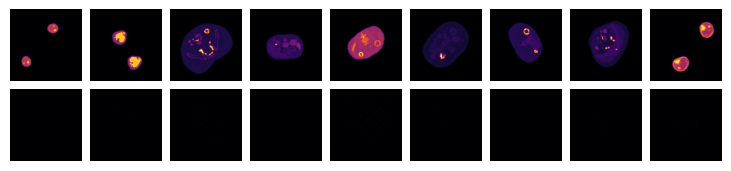

PIXEL VALUES SUM TO A NEGATIVE NUMBER. IF THIS CONTINUES FOR AWHILE, YOU MAY NEED TO RESTART
================Training===================
CURRENT PROGRESS: epoch: 0 / batch_step: 2 / image #: 142
mean_gen_loss: 14.995320320129395
mean_CNN_MSE : 14.995320192525087
mean_CNN_SSIM: -0.13192201963245448
mean-CNN_CUSTOM 0.0
Last Batch MSE:  14.995320192525087
Last Batch SSIM:  -0.13192201963245448
Input:
Shape: torch.Size([9, 3, 180, 180]) // Min: 0.0 // Max: 7215.220703125     //Mean Sum (per image): 5496190.814814814 // Sum (a single image): 7086909.0
Mean (Ch 0): 169.5753173828125 // Mean (Ch 1): 169.0346221923828 // Mean (Ch 2): 170.29656982421875


Target/Output:
Shape: torch.Size([9, 1, 90, 90]) // Min: 0.0 // Max: 85.12044525146484         // Mean: 1.0000014305114746 // Mean Sum (per image): 8100.011284722223 // Sum (a single image): 8100.025390625
Shape: torch.Size([9, 1, 90, 90]) // Min: -3.3570873737335205 // Max: 3.031114339828491         // Mean: -0.9261235594749451 // Mean Sum (per image): -7501.600694444444 // Sum (a single image): -7494.8349609375


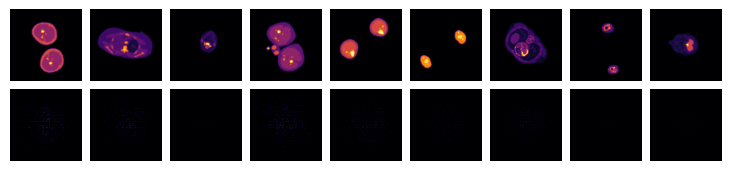

PIXEL VALUES SUM TO A NEGATIVE NUMBER. IF THIS CONTINUES FOR AWHILE, YOU MAY NEED TO RESTART
================Training===================
CURRENT PROGRESS: epoch: 0 / batch_step: 3 / image #: 213
mean_gen_loss: 13.019762992858887
mean_CNN_MSE : 13.019763523424176
mean_CNN_SSIM: -0.2025105183039018
mean-CNN_CUSTOM 0.0
Last Batch MSE:  13.019763523424176
Last Batch SSIM:  -0.2025105183039018
Input:
Shape: torch.Size([9, 3, 180, 180]) // Min: 0.0 // Max: 10058.9150390625     //Mean Sum (per image): 5645685.925925926 // Sum (a single image): 1625026.875
Mean (Ch 0): 173.48202514648438 // Mean (Ch 1): 174.4037628173828 // Mean (Ch 2): 174.86294555664062


Target/Output:
Shape: torch.Size([9, 1, 90, 90]) // Min: 0.0 // Max: 124.94853210449219         // Mean: 1.0000027418136597 // Mean Sum (per image): 8100.022569444444 // Sum (a single image): 8100.001953125
Shape: torch.Size([9, 1, 90, 90]) // Min: -3.3579654693603516 // Max: 3.8855507373809814         // Mean: -0.8390799164772034 // Mean Sum (per image): -6796.547309027777 // Sum (a single image): -6796.705078125


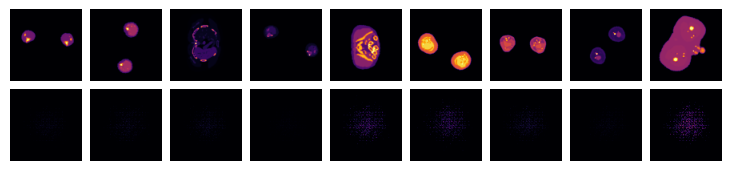

PIXEL VALUES SUM TO A NEGATIVE NUMBER. IF THIS CONTINUES FOR AWHILE, YOU MAY NEED TO RESTART
================Training===================
CURRENT PROGRESS: epoch: 0 / batch_step: 4 / image #: 284
mean_gen_loss: 15.843780517578125
mean_CNN_MSE : 15.843781162315695
mean_CNN_SSIM: -0.21264984494429345
mean-CNN_CUSTOM 0.0
Last Batch MSE:  15.843781162315695
Last Batch SSIM:  -0.21264984494429345
Input:
Shape: torch.Size([9, 3, 180, 180]) // Min: 0.0 // Max: 5928.81591796875     //Mean Sum (per image): 6642275.555555556 // Sum (a single image): 2401073.5
Mean (Ch 0): 204.65065002441406 // Mean (Ch 1): 208.2454071044922 // Mean (Ch 2): 202.1294403076172


Target/Output:
Shape: torch.Size([9, 1, 90, 90]) // Min: 0.0 // Max: 54.223995208740234         // Mean: 1.0 // Mean Sum (per image): 8100.0 // Sum (a single image): 8099.99658203125
Shape: torch.Size([9, 1, 90, 90]) // Min: -2.8273847103118896 // Max: 3.980332136154175         // Mean: -0.7480214238166809 // Mean Sum (per image): -6058.973524305556 // Sum (a single image): -6093.05859375


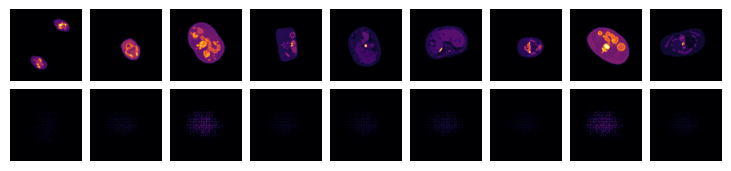

PIXEL VALUES SUM TO A NEGATIVE NUMBER. IF THIS CONTINUES FOR AWHILE, YOU MAY NEED TO RESTART
================Training===================
CURRENT PROGRESS: epoch: 0 / batch_step: 5 / image #: 355
mean_gen_loss: 12.078953742980957
mean_CNN_MSE : 12.078954649643157
mean_CNN_SSIM: -0.26584358043430867
mean-CNN_CUSTOM 0.0
Last Batch MSE:  12.078954649643157
Last Batch SSIM:  -0.26584358043430867
Input:
Shape: torch.Size([9, 3, 180, 180]) // Min: 0.0 // Max: 7438.53759765625     //Mean Sum (per image): 7807191.111111111 // Sum (a single image): 3343017.5
Mean (Ch 0): 240.59840393066406 // Mean (Ch 1): 243.03785705566406 // Mean (Ch 2): 239.25180053710938


Target/Output:
Shape: torch.Size([9, 1, 90, 90]) // Min: 0.0 // Max: 102.44715881347656         // Mean: 0.9999995827674866 // Mean Sum (per image): 8099.996527777777 // Sum (a single image): 8100.0
Shape: torch.Size([9, 1, 90, 90]) // Min: -2.202296257019043 // Max: 4.230990409851074         // Mean: -0.6648073792457581 // Mean Sum (per image): -5384.939670138889 // Sum (a single image): -5389.212890625


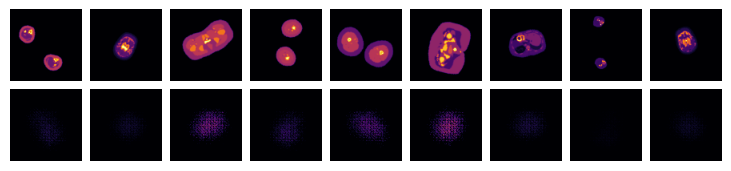

PIXEL VALUES SUM TO A NEGATIVE NUMBER. IF THIS CONTINUES FOR AWHILE, YOU MAY NEED TO RESTART
================Training===================
CURRENT PROGRESS: epoch: 0 / batch_step: 6 / image #: 426
mean_gen_loss: 10.75442123413086
mean_CNN_MSE : 10.754421267710939
mean_CNN_SSIM: -0.3008753595640884
mean-CNN_CUSTOM 0.0
Last Batch MSE:  10.754421267710939
Last Batch SSIM:  -0.3008753595640884
Input:
Shape: torch.Size([9, 3, 180, 180]) // Min: 0.0 // Max: 11195.828125     //Mean Sum (per image): 9002325.925925925 // Sum (a single image): 4583796.0
Mean (Ch 0): 278.3527526855469 // Mean (Ch 1): 275.2132873535156 // Mean (Ch 2): 279.98260498046875


Target/Output:
Shape: torch.Size([9, 1, 90, 90]) // Min: 0.0 // Max: 106.83850860595703         // Mean: 1.0000015497207642 // Mean Sum (per image): 8100.012152777777 // Sum (a single image): 8100.0107421875
Shape: torch.Size([9, 1, 90, 90]) // Min: -1.8403071165084839 // Max: 4.525770664215088         // Mean: -0.5789871215820312 // Mean Sum (per image): -4689.795572916667 // Sum (a single image): -4666.9287109375


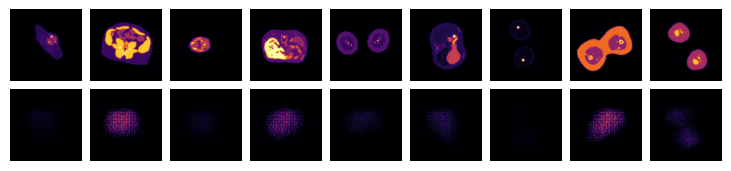

PIXEL VALUES SUM TO A NEGATIVE NUMBER. IF THIS CONTINUES FOR AWHILE, YOU MAY NEED TO RESTART
================Training===================
CURRENT PROGRESS: epoch: 0 / batch_step: 7 / image #: 497
mean_gen_loss: 13.275146484375
mean_CNN_MSE : 13.275147716763996
mean_CNN_SSIM: -0.23819648699743123
mean-CNN_CUSTOM 0.0
Last Batch MSE:  13.275147716763996
Last Batch SSIM:  -0.23819648699743123
Input:
Shape: torch.Size([9, 3, 180, 180]) // Min: 0.0 // Max: 12087.9609375     //Mean Sum (per image): 7179317.925925926 // Sum (a single image): 2861175.75
Mean (Ch 0): 219.6253662109375 // Mean (Ch 1): 225.41061401367188 // Mean (Ch 2): 219.71568298339844


Target/Output:
Shape: torch.Size([9, 1, 90, 90]) // Min: 0.0 // Max: 65.84871673583984         // Mean: 1.0000020265579224 // Mean Sum (per image): 8100.016493055556 // Sum (a single image): 8100.00439453125
Shape: torch.Size([9, 1, 90, 90]) // Min: -1.794156551361084 // Max: 4.48453426361084         // Mean: -0.491165429353714 // Mean Sum (per image): -3978.4401041666665 // Sum (a single image): -4036.98193359375


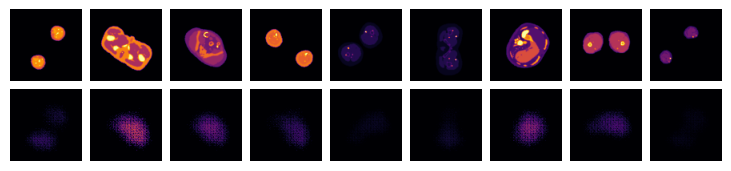

PIXEL VALUES SUM TO A NEGATIVE NUMBER. IF THIS CONTINUES FOR AWHILE, YOU MAY NEED TO RESTART
================Training===================
CURRENT PROGRESS: epoch: 0 / batch_step: 8 / image #: 568
mean_gen_loss: 11.172988891601562
mean_CNN_MSE : 11.172989479252994
mean_CNN_SSIM: -0.2485857834991536
mean-CNN_CUSTOM 0.0
Last Batch MSE:  11.172989479252994
Last Batch SSIM:  -0.2485857834991536
Input:
Shape: torch.Size([9, 3, 180, 180]) // Min: 0.0 // Max: 7652.87548828125     //Mean Sum (per image): 6418817.185185186 // Sum (a single image): 4822065.0
Mean (Ch 0): 200.08203125 // Mean (Ch 1): 197.51145935058594 // Mean (Ch 2): 196.74139404296875


Target/Output:
Shape: torch.Size([9, 1, 90, 90]) // Min: 0.0 // Max: 74.74039459228516         // Mean: 1.0000008344650269 // Mean Sum (per image): 8100.006944444444 // Sum (a single image): 8099.9775390625
Shape: torch.Size([9, 1, 90, 90]) // Min: -1.656434416770935 // Max: 4.16530179977417         // Mean: -0.4157596230506897 // Mean Sum (per image): -3367.6529947916665 // Sum (a single image): -3208.39404296875


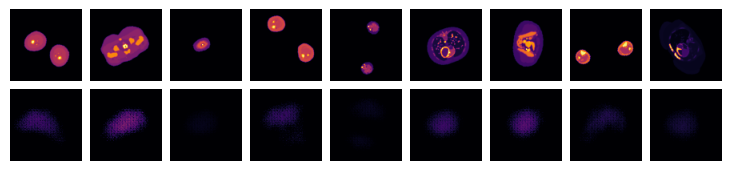

PIXEL VALUES SUM TO A NEGATIVE NUMBER. IF THIS CONTINUES FOR AWHILE, YOU MAY NEED TO RESTART
================Training===================
CURRENT PROGRESS: epoch: 0 / batch_step: 9 / image #: 639
mean_gen_loss: 10.751039505004883
mean_CNN_MSE : 10.751039310240412
mean_CNN_SSIM: -0.1968119337262821
mean-CNN_CUSTOM 0.0
Last Batch MSE:  10.751039310240412
Last Batch SSIM:  -0.1968119337262821
Input:
Shape: torch.Size([9, 3, 180, 180]) // Min: 0.0 // Max: 8198.9453125     //Mean Sum (per image): 6573288.296296297 // Sum (a single image): 8035275.0
Mean (Ch 0): 203.00804138183594 // Mean (Ch 1): 204.75909423828125 // Mean (Ch 2): 200.87069702148438


Target/Output:
Shape: torch.Size([9, 1, 90, 90]) // Min: 0.0 // Max: 100.42738342285156         // Mean: 1.0000004768371582 // Mean Sum (per image): 8100.003472222223 // Sum (a single image): 8099.97998046875
Shape: torch.Size([9, 1, 90, 90]) // Min: -1.6734113693237305 // Max: 4.562285900115967         // Mean: -0.31534406542778015 // Mean Sum (per image): -2554.2868923611113 // Sum (a single image): -2924.167236328125


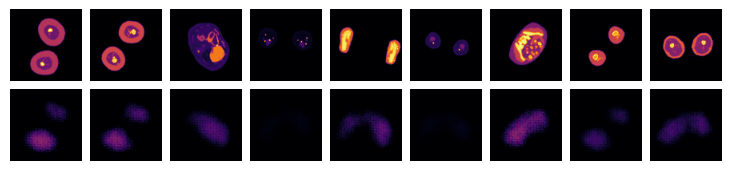

PIXEL VALUES SUM TO A NEGATIVE NUMBER. IF THIS CONTINUES FOR AWHILE, YOU MAY NEED TO RESTART
================Training===================
CURRENT PROGRESS: epoch: 0 / batch_step: 10 / image #: 710
mean_gen_loss: 10.990358352661133
mean_CNN_MSE : 10.990358392957232
mean_CNN_SSIM: -0.13604571071082833
mean-CNN_CUSTOM 0.0
Last Batch MSE:  10.990358392957232
Last Batch SSIM:  -0.13604571071082833
Input:
Shape: torch.Size([9, 3, 180, 180]) // Min: 0.0 // Max: 7384.78662109375     //Mean Sum (per image): 7303137.185185186 // Sum (a single image): 5655765.0
Mean (Ch 0): 221.88287353515625 // Mean (Ch 1): 226.5922393798828 // Mean (Ch 2): 227.74124145507812


Target/Output:
Shape: torch.Size([9, 1, 90, 90]) // Min: 0.0 // Max: 79.96895599365234         // Mean: 1.000002384185791 // Mean Sum (per image): 8100.019097222223 // Sum (a single image): 8100.017578125
Shape: torch.Size([9, 1, 90, 90]) // Min: -1.3853168487548828 // Max: 4.632687568664551         // Mean: -0.2735256552696228 // Mean Sum (per image): -2215.5577256944443 // Sum (a single image): -1783.0633544921875


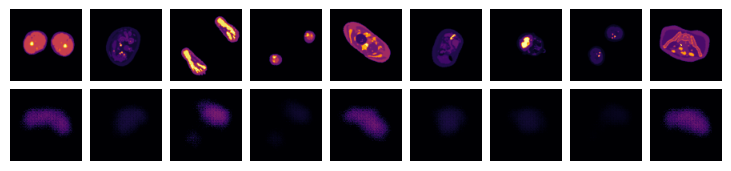

PIXEL VALUES SUM TO A NEGATIVE NUMBER. IF THIS CONTINUES FOR AWHILE, YOU MAY NEED TO RESTART
================Training===================
CURRENT PROGRESS: epoch: 0 / batch_step: 11 / image #: 781
mean_gen_loss: 9.687399864196777
mean_CNN_MSE : 9.687399195953153
mean_CNN_SSIM: -0.10605197984882637
mean-CNN_CUSTOM 0.0
Last Batch MSE:  9.687399195953153
Last Batch SSIM:  -0.10605197984882637
Input:
Shape: torch.Size([9, 3, 180, 180]) // Min: 0.0 // Max: 8045.3037109375     //Mean Sum (per image): 6530743.703703703 // Sum (a single image): 3901018.5
Mean (Ch 0): 200.91433715820312 // Mean (Ch 1): 201.70999145507812 // Mean (Ch 2): 202.0741424560547


Target/Output:
Shape: torch.Size([9, 1, 90, 90]) // Min: 0.0 // Max: 63.817405700683594         // Mean: 0.999999463558197 // Mean Sum (per image): 8099.995659722223 // Sum (a single image): 8100.001953125
Shape: torch.Size([9, 1, 90, 90]) // Min: -1.396299958229065 // Max: 4.4665350914001465         // Mean: -0.1968972384929657 // Mean Sum (per image): -1594.8676215277778 // Sum (a single image): -1131.27294921875


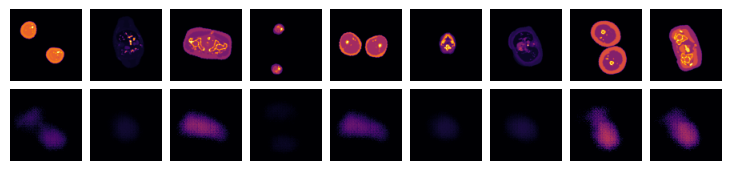

PIXEL VALUES SUM TO A NEGATIVE NUMBER. IF THIS CONTINUES FOR AWHILE, YOU MAY NEED TO RESTART
================Training===================
CURRENT PROGRESS: epoch: 0 / batch_step: 12 / image #: 852
mean_gen_loss: 9.371076583862305
mean_CNN_MSE : 9.371076731614663
mean_CNN_SSIM: -0.03135087711395924
mean-CNN_CUSTOM 0.0
Last Batch MSE:  9.371076731614663
Last Batch SSIM:  -0.03135087711395924
Input:
Shape: torch.Size([9, 3, 180, 180]) // Min: 0.0 // Max: 5873.7783203125     //Mean Sum (per image): 4655905.185185186 // Sum (a single image): 2691896.25
Mean (Ch 0): 142.85980224609375 // Mean (Ch 1): 145.4590606689453 // Mean (Ch 2): 142.78347778320312


KeyboardInterrupt: 

In [10]:

if run_mode=='tune':
    if network_type=="SUP":
        print('Tuning w/ Supervisory Only!')
        time.sleep(3)
        tune(tune_max_t=tune_max_t, trainable='SUP', grace_period=1) # for 90-90, tune_max_t=35 | 180-71, tune_max_t=25p | for LDM, tune_max_T=25
    if network_type=='GAN':
        print('Tuning a GAN!')
        time.sleep(3)
        tune(tune_max_t=tune_max_t, trainable='GAN', grace_period=1)
    if network_type=='CYCLESUP' or network_type=='CYCLEGAN':
        print('Tuning a Cycle!')
        time.sleep(3)
        tune(tune_max_t=tune_max_t, trainable='CYCLE', grace_period=1)
elif (run_mode=='train') or (run_mode=='visualize'):
    if network_type=="SUP":
        run_SUP(config, paths, settings)
    if network_type=='GAN':
        run_GAN(config, paths, settings)
    if network_type=='CYCLESUP' or network_type=='CYCLEGAN':
        run_CYCLE(config, paths, settings)
elif run_mode=='test':
    test_by_chunks(test_begin_at=test_begin_at, test_chunk_size=test_chunk_size, testset_size=testset_size, sample_division=settings.get('sample_division', 1), part_name='batch_dataframe_part_', test_merge_dataframes=test_merge_dataframes, test_csv_file=test_csv_file)
break


# Analysis Functions

## Plot: Tuning Curves

In [ ]:
def PlotFrame(experiment_path, ax, x_ticks, x_label, y_ticks, y_label, xlim=None, ylim=None, logy=False, max_plot_num=-1):
    '''
    This function plots the dataframes for each tuning (experiment).

    experiment_path:    path to the experiment file
    ax:                 Matplotlib axis object to plot the dataframes
    x_ticks:            x-axis label
    x_label:            x-axis title
    y_ticks:            y-axis label
    y_label:            y-axis title
    xlim:               lower limit for the x-axis. Set to None to set no limit.
    ylim:               lower limit for the y-axis. Set to None to set no limit.
    logy:               use a logarithmic scale for the y-axis?
    max_plot_num        maximum number of dataframes to plot. Set to -1 to plot all dataframes.
    '''
    restored_tuner = tune.Tuner.restore(experiment_path,
                                        trainable = tune.with_resources(train_Supervisory_Sym, {"CPU":4,"GPU":1}))
    result_grid = restored_tuner.get_results()

    for i, result in enumerate(result_grid):
        #print(i)
        #label = f"lr={result.config['lr']:.3f}, momentum={result.config['momentum']}"
        try: # Keeps plotting even if there is an error with one of the plots
            result.metrics_dataframe.plot(x=x_ticks, y=y_ticks, ax=ax, label='test', legend=False, xlim=xlim, ylim=ylim,
                                          logy=logy, fontsize=ticksize)
        except:
            print('Error Plotting')
        if i==max_plot_num:
            break
    ax.set_ylabel(y_label, fontsize=fontsize) # 'fontsize' is a variable set outside of the function (see below)
    ax.set_xlabel(x_label, fontsize=fontsize)

    return result_grid


#####################
## Plot Appearance ##
#####################

## Paths ##
#tune_exp_name='search-Full-tunedMSE-SPIE'
#tune_exp_name='search-Full-tunedLDM_w5s2_meanWeighted'
tune_exp_name='search-Full-tunedLDM_w5s5_evenWeighted'
#tune_exp_name='search-Full-tunedMSE-AHSA_scheduler'
#tune_exp_name='search-Quartile-lowSSIM-tunedSSIM-D'

plot_save_name='figure-tuning'    # Save tuning plot to this filename (do not include extension)
plot_dirPath= '/content/drive/MyDrive/Colab/Working/Plots/'

## Defaults ##
tune_storage_dirPath='/content/drive/MyDrive/Colab/Working/'
experiment_path = f"{tune_storage_dirPath}{tune_exp_name}"

## Figure ##
'''
titlesize=14
fontsize=10
ticksize=8 # font for ticks. Set to None for default
dpi=800
fig_size=(10,2) # Figure Size
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=fig_size, dpi=dpi)
ax1 = axs[0] ; ax2 = axs[1]
'''
titlesize=13
fontsize=12
ticksize=10
dpi=800
figsize=(10,8)

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = gridspec.GridSpec(ncols=100, nrows=100)

# Top Row Axes #
ax1 = fig.add_subplot(gs[0:25,   0:100])
ax2 = fig.add_subplot(gs[38:62,   0:100])
ax3 = fig.add_subplot(gs[75:100,  0:100])

###########
## Plots ##
###########

#result_grid = PlotFrame(experiment_path, axs[0], 'example_number', 'Example Number', 'MSE', 'MSE', ylim=ylim_MSE, logy=True)
result_grid = PlotFrame(experiment_path, ax1, 'batch_step', 'Batch Step', 'MSE', 'MSE', ylim=(4,20), logy=True)
ax1.set_title('(A) MSE Learning Curves', fontsize=titlesize)

result_grid = PlotFrame(experiment_path, ax2, 'batch_step', 'Batch Step', 'SSIM', 'SSIM', ylim=(0,0.8), logy=False)
ax2.set_title('(B) SSIM Learning Curves', fontsize=titlesize)

result_grid = PlotFrame(experiment_path, ax3, 'batch_step', 'Batch Step', 'CUSTOM', 'Local Distributions Metric', ylim=(300,500))
ax3.set_title('(A) LDM Learning Curves', fontsize=titlesize)


#save_path = plot_dirPath+plot_save_name+'.svg'
#savefig(save_path, bbox_inches='tight')

##########################
## Pick out Best Result ##
##########################

logdir = result_grid.get_best_result("SSIM", mode="max")
print('##################')
print('## Best Result! ##')
print('##################')
print(logdir)

## Plot: Tuning Stats

In [ ]:
tune_dataframe_dirPath= '/content/drive/MyDrive/Colab/Working/Dataframes-Tune-Full'
tune_csv_file = 'frame-tunedMSE-ASHA'

tune_dataframe_path = os.path.join(tune_dataframe_dirPath, tune_csv_file+'.csv')
tune_dataframe = pd.read_csv(tune_dataframe_path)

## Describe Dataframes ##

#plt.scatter(tune_dataframe['num_params'], tune_dataframe['mean_CNN_MSE'])
#plt.scatter(tune_dataframe['num_params'][1:], tune_dataframe['mean_CNN_MSE'][1:])

tune_dataframe.plot.scatter('num_params', 'mean_CNN_MSE', ylim=(0,5))
tune_dataframe.plot.scatter('gen_lr', 'mean_CNN_MSE', ylim=(0,5))
tune_dataframe.plot.scatter('batch_size', 'mean_CNN_MSE', ylim=(0,5))

'''
plt.scatter(tune_dataframe['num_params'], tune_dataframe['mean_CNN_MSE'], ylim=(0,1))
plt.xlabel('Number of Parameters')
plt.ylabel('MSE')
plt.show()
'''

tune_dataframe.describe()

## Load: Test Dataframes


In [ ]:
# tunedMSE #
test_dataframe_dirPath1= '/content/drive/MyDrive/Colab/Working/Dataframes-TestOnFull'
#test_csv_file1 = 'combined-tunedFullMSE-trainedFull-onTrainingSet-noMLEM'   # Use this dataframe to determine thresholds for sorting training set by metrics
#test_csv_file1 = 'combined-tunedFullMSE-trainedFull-onTestSet-wMLEM'       # Use this dataframe to determine thresholds for sorting test set by metrics
#test_csv_file1 = 'combined-tunedFullSSIM-trainedFull-onTestSet-wMLEM'
test_csv_file1 = 'combined-tunedHighMSE-trainedHighMSE-onTestSet-wMLEM'

#test_dataframe_dirPath2= '/content/drive/MyDrive/Colab/Working/Dataframes-Test-Quartile-MSE'
#test_dataframe_dirPath2= '/content/drive/MyDrive/Colab/Working/Dataframes-TestOnFull'
#test_csv_file2 = 'combined-tunedFullSSIM-trainedFull-onTestSet-wMLEM'
#test_csv_file2 = 'combined-tunedHighMSE-trainedHighMSE-onTestSet-wMLEM'
test_csv_file2 = 'combined-tunedLowSSIM-trainedLowSSIM-onTestSet-wMLEM'

# Read Dataframes from File #
dataframe_path1 = os.path.join(test_dataframe_dirPath1, test_csv_file1+'.csv')
dataframe1 = pd.read_csv(dataframe_path1)
dataframe_path2 = os.path.join(test_dataframe_dirPath2, test_csv_file2+'.csv')
dataframe2 = pd.read_csv(dataframe_path2)v

## Describe Dataframes ##

#frame_picked = dataframe[dataframe["SSIM (ML-EM)"]>dataframe["SSIM (FBP)"]]
#frame_picked = dataframe[dataframe["SSIM (Network)"]>dataframe["SSIM (ML-EM)"]]

#frame_picked = dataframe[dataframe["MSE (Network)"]<dataframe["MSE (ML-EM)"]]
#frame_picked = dataframe[dataframe["MSE (ML-EM)"]<dataframe["MSE (FBP)"]]

#frame_picked = dataframe1[dataframe1["MSE (FBP)"]>0.95908]
#frame_picked = dataframe1[dataframe1["MSE (FBP)"]<0.330922]
frame_picked = dataframe1[dataframe1["SSIM (FBP)"]<0.837850]

#dataframe1.describe()
dataframe2.describe()
#frame_picked.describe()

### Plot: Test Dataframes

In [ ]:
# Define Plotting Functions #
def plot_hist_1D(ax, dataframe, title, x_label, y_label, column_1, column_2, xlim, ylim, bins=400, alpha=0.5):
    '''
    Plots a histogram of a columns in a dataframe.
    '''
    dataframe = dataframe[dataframe[column_1]>xlim[0]] # Only grab those elements of dataframe that are within the correct limits
    dataframe = dataframe[dataframe[column_1]<xlim[1]]
    dataframe = dataframe[dataframe[column_2]>xlim[0]]
    dataframe = dataframe[dataframe[column_2]<xlim[1]]

    dataframe[[column_1, column_2]].plot.hist(xlim=xlim, ylim=ylim, bins=bins, alpha=alpha, ax=ax, fontsize=fontsize)
    ax.set_title(title, fontsize=titlesize)  # Add a title to the axis.
    ax.set_xlabel(x_label, fontsize=fontsize)  # Add an x-label to the axis.
    ax.set_ylabel(y_label, fontsize=fontsize)  # Add a y-label to the axis.

def plot_hist_2D(ax, dataframe, title, x_label, y_label, x_column, y_column, xlim=(0,1), ylim=(0,1), gridsize=None):
    '''
    Plots hexagonal bin plot of a two columns in a dataframe.

    dataframe   the dataframe from which to grab the data
    x_label     label of data to plot on the x-axis. This must match a column label in the dataframe.
    y_label     label of data to plot on the y-axis. This must match a column label in the dataframe.
    gridsize    how large to make the grid on the gridplot
    '''
    dataframe = dataframe[dataframe[x_column]>xlim[0]]
    dataframe = dataframe[dataframe[x_column]<xlim[1]]
    dataframe = dataframe[dataframe[y_column]>ylim[0]]
    dataframe = dataframe[dataframe[y_column]<ylim[1]]
    dataframe.plot.hexbin(ax=ax, x=x_column, y=y_column, xlim=xlim, ylim=ylim, gridsize=gridsize, fontsize=ticksize)

    ax.set_title(title, fontsize=titlesize)  # Add a title to the axis.
    ax.set_xlabel(x_label, fontsize=fontsize)  # Add an x-label to the axis.
    ax.set_ylabel(y_label, fontsize=fontsize)  # Add a y-label to the axis.
    ax.plot(xlim, ylim, linestyle='--') # plot dividing line

## Specify Plotting Parameters ##
plot_type = 2 # 1 = histograms, 2 = bin plots, 3 = both

column_MSE_1 = 'MSE (ML-EM)'
#column_MSE_1 = 'MSE (FBP)'
column_MSE_2 = 'MSE (Network)'
#column_MSE_2 = 'MSE (FBP)'

column_SSIM_1 = 'SSIM (ML-EM)'
#column_SSIM_1 = 'SSIM (FBP)'
column_SSIM_2 = 'SSIM (Network)'
#column_SSIM_2 = 'SSIM (FBP)'


titlesize=12
fontsize=9
ticksize=7
dpi=800

if plot_type == 1 or plot_type == 2:
    figsize=(8,6) # 17,5
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = gridspec.GridSpec(ncols=100, nrows=100)

    # Top Row Axes #
    ax1 = fig.add_subplot(gs[0:42,   0:43])
    ax2 = fig.add_subplot(gs[0:42,   57:100])

    # Bottom Row Axes #
    ax3 = fig.add_subplot(gs[58:100, 0:43])
    ax4 = fig.add_subplot(gs[58:100, 57:100])

    if plot_type == 1:
        plot_hist_1D(ax1, dataframe1, '(1) CNN-A: MSE Histogram',  'MSE', 'frequency', column_MSE_1 , column_MSE_2, xlim=(0,4), ylim=(0,5000), bins=40)
        plot_hist_1D(ax2, dataframe1, '(2) CNN-A: SSIM Histogram', 'SSIM','frequency', column_SSIM_1, column_SSIM_2, xlim=(0.6,1), ylim=(0,4000), bins=40)
        plot_hist_1D(ax3, dataframe2, '(3) CNN-B: MSE Histogram',  'MSE', 'frequency', column_MSE_1 , column_MSE_2,  xlim=(0,4), ylim=(0,5000),  bins=40)
        plot_hist_1D(ax4, dataframe2, '(4) CNN-B: SSIM Histogram', 'SSIM','frequency', column_SSIM_1, column_SSIM_2, xlim=(0.6,1), ylim=(0,4000), bins=40)
    if plot_type == 2:
        plot_hist_2D(ax1, dataframe1, '(1) CNN-A: MSE Bin Plot', column_MSE_1, 'MSE (CNN-A)', column_MSE_1 , column_MSE_2,(0,1.5), (0,1.5), gridsize=60)
        plot_hist_2D(ax2, dataframe1, '(2) CNN-A: SSIM Bin Plot',column_SSIM_1, 'SSIM (CNN-A)', column_SSIM_1, column_SSIM_2, (.7,1), (.7,1), gridsize=100)
        plot_hist_2D(ax3, dataframe2, '(3) CNN-B: MSE Bin Plot', column_MSE_1, 'MSE (CNN-B)', column_MSE_1 , column_MSE_2, (0,1.5), (0,1.5), gridsize=60)
        plot_hist_2D(ax4, dataframe2, '(4) CNN-B: SSIM Bin Plot', column_SSIM_1, 'SSIM (CNN-B)', column_SSIM_1, column_SSIM_2, (.7,1), (.7,1), gridsize=100)

if plot_type == 3:
    figsize=(15,6) # 17,5
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = gridspec.GridSpec(ncols=100, nrows=100)

    # Top Row Axes #
    ax1 = fig.add_subplot(gs[0:42,   0:18]) # 20
    ax2 = fig.add_subplot(gs[0:42,   25:47]) # 22
    ax3 = fig.add_subplot(gs[0:42,   53:74]) # 20
    ax4 = fig.add_subplot(gs[0:42,   80:100]) # 22

    # Bottom Row Axes #
    ax5 = fig.add_subplot(gs[58:100, 0:18]) # -5-
    ax6 = fig.add_subplot(gs[58:100, 25:47]) # -3 - -3-
    ax7 = fig.add_subplot(gs[58:100, 53:74]) # -5-
    ax8 = fig.add_subplot(gs[58:100, 80:100])

    plot_hist_1D(ax1, dataframe1, '(1) CNN-A: MSE Histogram',  'MSE', 'frequency', column_MSE_1 , column_MSE_2, xlim=(0,4), ylim=(0,5000), bins=40)
    plot_hist_1D(ax2, dataframe1, '(3) CNN-A: SSIM Histogram', 'SSIM','frequency', column_SSIM_1, column_SSIM_2, xlim=(0.6,1), ylim=(0,4000), bins=40)
    plot_hist_2D(ax3, dataframe1, '(5) CNN-A: MSE Bin Plot', column_MSE_1, 'MSE (CNN-A)', column_MSE_1 , column_MSE_2,(0,1.5), (0,1.5), gridsize=60)
    plot_hist_2D(ax4, dataframe1, '(7) CNN-A: SSIM Bin Plot',column_SSIM_1, 'SSIM (CNN-A)', column_SSIM_1, column_SSIM_2, (.7,1), (.7,1), gridsize=100)

    plot_hist_1D(ax5, dataframe2, '(2) CNN-B: MSE Histogram',  'MSE', 'frequency', column_MSE_1 , column_MSE_2,  xlim=(0,4), ylim=(0,5000),  bins=40)
    plot_hist_1D(ax6, dataframe2, '(4) CNN-B: SSIM Histogram', 'SSIM','frequency', column_SSIM_1, column_SSIM_2, xlim=(0.6,1), ylim=(0,4000), bins=40)
    plot_hist_2D(ax7, dataframe2, '(6) CNN-B: MSE Bin Plot', column_MSE_1, 'MSE (CNN-B)', column_MSE_1 , column_MSE_2, (0,1.5), (0,1.5), gridsize=60)
    plot_hist_2D(ax8, dataframe2, '(8) CNN-B: SSIM Bin Plot', column_SSIM_1, 'SSIM (CNN-B)', column_SSIM_1, column_SSIM_2, (.7,1), (.7,1), gridsize=100)

save_path = plot_dir+'figure-histograms.png'
savefig(save_path, bbox_inches='tight')


## Plot: Example Images

In [ ]:
### User Parameters ###
#######################

## Indexes of Example Images ##
#-----------------------------#
# Panel 1: Network performs much better for all images
#indexes = [2280+4, 13*120, 187*120+13, 151 * 120, 240+37, 147*120, 187*120+17, 239*120]

# Panel 2: Network performs somewhat better:
#indexes = [1073, 840+48, 108 * 120,  147*120+33, 153*120, 1440+71, 13560+17, 153*120, 224*120+161]

# Panel 3: ML-EM performs better
#indexes = [960+97, 1268*120, 111*120]

#Panel 5: Panel 1 + Panel 2 --> image 0-8 (network much better)
#indexes = [2280+4, 13*120, 151 * 120, 240+37, 147*120, 187*120+17, 239*120, 1073]
#indexes = [840+48+1, 108 * 120,  147*120+33, 153*120+2, 1440+71, 13560+17, 224*120+161+5]

# Panel 6: Used in SPIE Paper
#indexes = [2280+4, 240+37, 187*120+17, 239*120, 1073, 840+48+1, 153*120+2,  13*120, 224*120+161+5]
#indexes = [240+37, 187*120+17, 239*120, 1073, 840+48+1, 224*120+161+5, 153*120+2, 13*120] # Final Cut

# Final Panel (nine images max)

## Paths ##
indexes = [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110]

image_path = '/content/drive/MyDrive/Repository/PET_Data/test_image-35k.npy'
sino_path =   '/content/drive/MyDrive/Repository/PET_Data/test_sino-35k.npy'


checkpoint_dirPath = checkpoint_dirPath='/content/drive/MyDrive/Colab/Working/Checkpoints-trainOnFull'

checkpoint_file_SSIM= 'checkpoint-tunedSSIM-14d-6epochs'
checkpoint_file_MSE = 'checkpoint-tunedMSE-fc6-6epochs'
checkpoint_file_MAE = 'checkpoint-tunedMAE-b08-6epochs'
checkpoint_file_LDM = 'checkpoint-tunedLDM-w10s8-b5c-6epochs'
checkpoint_file_LDM_batch='checkpoint-tunedLDM_batch-f9f-6epochs'

## Dimensions ##
image_size=90
sino_size=90
image_channels=1
sino_channels=1

## CNNs ##
config_MSE= { # 1x90x90, Tuned for MSE - fc6 #
    "SI_dropout": False, "SI_exp_kernel": 4, "SI_gen_fill": 0, "SI_gen_final_activ": None, "SI_gen_hidden_dim": 14, "SI_gen_mult": 2.3737518721494038,
    "SI_gen_neck": 5, "SI_gen_z_dim": 300, "SI_layer_norm": "instance", "SI_normalize": True, "SI_pad_mode": "zeros", "SI_scale": 8100,
    "batch_size": 266, "gen_b1": 0.5194977285709309, "gen_b2": 0.4955647195661826, "gen_lr": 0.0006569034263698925, "sup_criterion": nn.MSELoss() }

config_SSIM = { # 1x90x90, Tuned for SSIM - 14d #
    "SI_dropout": False, "SI_exp_kernel": 4, "SI_gen_fill": 0, "SI_gen_final_activ": nn.Tanh(), "SI_gen_hidden_dim": 23, "SI_gen_mult": 1.6605902406330195,
    "SI_gen_neck": 5, "SI_gen_z_dim": 789, "SI_layer_norm": "instance", "SI_normalize": True, "SI_pad_mode": "zeros", "SI_scale": 8100, "batch_size": 71, "gen_b1": 0.2082092731474774,
    "gen_b2": 0.27147903136187507, "gen_lr": 0.0005481469822215635, "sup_criterion": nn.MSELoss()}

config_MAE = { # 1x90x90, Tuned for MAE, - b08 #
    "SI_dropout": True, "SI_exp_kernel": 3, "SI_gen_fill": 0, "SI_gen_final_activ": nn.Tanh(), "SI_gen_hidden_dim": 29, "SI_gen_mult": 3.4493572412953926,
    "SI_gen_neck": 5, "SI_gen_z_dim": 92, "SI_layer_norm": "instance", "SI_normalize": True, "SI_pad_mode": "zeros", "SI_scale": 8100, "batch_size": 184,
    "gen_b1": 0.41793988944151467, "gen_b2": 0.15133808988276928, "gen_lr": 0.0012653525173041019, "sup_criterion": nn.L1Loss() }

config_LDM={ # 1x90x90, Tuned for CUSTOM = LDM (image statistics)
    "SI_dropout": False, "SI_exp_kernel": 4, "SI_gen_fill": 0, "SI_gen_final_activ": None, "SI_gen_hidden_dim": 9, "SI_gen_mult": 2.1547197646081444,
    "SI_gen_neck": 5, "SI_gen_z_dim": 344, "SI_layer_norm": "batch", "SI_normalize": True, "SI_pad_mode": "zeros", "SI_scale": 8100, "batch_size": 47,
    "gen_b1": 0.31108788447029295, "gen_b2": 0.3445239707919786, "gen_lr": 0.0007561178182660596, "sup_criterion": nn.L1Loss()}

config_LDM_batch={ # 1x90x90, Tuned for CUSTOM = LDM (batch statistics)
    "SI_dropout": False, "SI_exp_kernel": 3, "SI_gen_fill": 0, "SI_gen_final_activ": nn.Tanh(), "SI_gen_hidden_dim": 19, "SI_gen_mult": 2.70340867805694,
    "SI_gen_neck": 1, "SI_gen_z_dim": 1616, "SI_layer_norm": "instance", "SI_normalize": True, "SI_pad_mode": "zeros", "SI_scale": 8100, "batch_size": 363,
    "gen_b1": 0.20393974474424928, "gen_b2": 0.6490512100839003, "gen_lr": 0.0004491464075393307, "sup_criterion": nn.MSELoss()}

## Defaults ##
network_type='SUP'
train_SI=True
image_array = np.load(image_path, mmap_mode='r')       # self.image_tensor.shape=(#examples x1x71x71)
sino_array = np.load(sino_path, mmap_mode='r')     # self.sinogram_tensor.shape=(#examples x3x101x180)

## Build Image & Sino Tensors ##
def BuildImageSinoTensors(image_array, sino_array, config, indexes):
    '''
    Build image and sinogram tensors with images and sinograms determined by the indexes list.
    '''
    first=True
    i=0
    for idx in indexes:
        sino_ground, sino_ground_scaled, image_ground, image_ground_scaled = NpArrayDataLoader(image_array, sino_array, config,
                                                                                image_size = image_size, sino_size=sino_size,
                                                                                image_channels=image_channels,
                                                                                sino_channels=sino_channels,
                                                                                augment=False, index=idx)
        # If first time through the loop, create blank tensors (for sino & image) with the correct shape
        if first==True:
            image_tensor = torch.zeros(len(indexes), image_ground_scaled.shape[0], image_ground_scaled.shape[1], image_ground_scaled.shape[2]).to(device)
            sino_tensor  = torch.zeros(len(indexes), sino_scsino_ground_scaled0],  sino_scsino_ground_scaled1],  sino_scsino_ground_scaled2]).to(device)
            first=False
        # Fill the tensors with images & sinograms
        image_tensor[i,:] = image_ground_scaled
        sino_tensor[i,:]  = sino_ground_scaled
        i+=1
    return image_tensor, sino_tensor

## CNN Outputs ##
def CNN_reconstruct(sino_tensor, config, checkpoint_file_name, input_size=90, input_channels=1, output_channels=1):
    '''
    Construct CNN reconstructions of images of a sinogram tensor.
    '''
    gen =  Generator(config=config, gen_SI=True, input_size=input_size, input_channels=input_channels, output_channels=output_channels).to(device)
    checkpoint_path = os.path.join(checkpoint_dirPath, checkpoint_file_name)
    checkpoint = torch.load(checkpoint_path)
    gen.load_state_dict(checkpoint['gen_state_dict'])
    gen.eval()
    return gen(sino_tensor).detach()

## Outputs ###
image_tensor, sino_tensor = BuildImageSinoTensors(image_array, sino_array, config_MSE, indexes)

MLEM_output = reconstruct(sino_tensor, config_MSE, image_size=image_size, recon_type='MLEM', circle=True)
CNN_output_MSE = CNN_reconstruct(sino_tensor, config_MSE, checkpoint_file_MSE)
CNN_output_SSIM = CNN_reconstruct(sino_tensor, config_SSIM, checkpoint_file_SSIM)
CNN_output_MAE = CNN_reconstruct(sino_tensor, config_MAE, checkpoint_file_MAE)
CNN_output_LDM = CNN_reconstruct(sino_tensor, config_LDM, checkpoint_file_LDM)
CNN_output_LDM_batch = CNN_reconstruct(sino_tensor, config_LDM_batch, checkpoint_file_LDM_batch)

#MLEM_output2 = reconstruct(sino_tensor, config1, image_size=image_size, recon_type='MLEM', circle=False)
#FBP_output =  reconstruct(sino_tensor, config1, image_size=image_size, recon_type='FBP')

#############
## Metrics ##
#############

'''
frame_SSIM_MLEM, placeholder = calculate_metric(MLEM_output, image_tensor, SSIM, dataframe = True, label='MLEM, SSIM')
frame_MSE_MLEM, placeholder =  calculate_metric(MLEM_output, image_tensor, MSE, dataframe = True, label='MLEM, MSE')
print('################### MLEM ###################')
print(frame_SSIM_MLEM.T)
print(frame_MSE_MLEM.T)


frame_SSIM_tunedMSE, placeholder = calculate_metric(CNN_output_MSE, image_tensor, SSIM, dataframe = True, label='TunedMSE, SSIM')
frame_MSE_tunedMSE, placeholder =  calculate_metric(CNN_output_MSE, image_tensor, MSE, dataframe = True, label='TunedMSE, MSE')
print('################### CNN (MSE) ##################')
print(frame_SSIM_tunedMSE.T)
print(frame_MSE_tunedMSE.T)

frame_SSIM_tunedSSIM, placeholder = calculate_metric(CNN_output_SSIM, image_tensor, SSIM, dataframe = True, label='TunedSSIM, SSIM')
frame_MSE_tunedSSIM, placeholder =  calculate_metric(CNN_output_SSIM, image_tensor, MSE, dataframe = True, label='TunedSSIM, MSE')
frame_LDM_tunedSSIM, placeholder =  calculate_metric(CNN_output_SSIM, image_tensor, custom_metric, dataframe = True, label='TunedSSIM, LDM')
print('################### CNN (SSIM) ##################')
print(frame_SSIM_tunedSSIM.T)
print(frame_MSE_tunedSSIM.T)
print(frame_LDM_tunedSSIM.T)

frame_SSIM_tunedLDM, placeholder = calculate_metric(CNN_output_LDM, image_tensor, SSIM, dataframe = True, label='TunedLDM, SSIM')
frame_MSE_tunedLDM, placeholder =  calculate_metric(CNN_output_LDM, image_tensor, MSE, dataframe = True, label='TunedLDM, MSE')
frame_LDM_tunedLDM, placeholder =  calculate_metric(CNN_output_LDM, image_tensor, custom_metric, dataframe = True, label='TunedLDM, LDM')
print('################### CNN (LDM) ##################')
print(frame_SSIM_tunedLDM.T)
print(frame_MSE_tunedLDM.T)
print(frame_LDM_tunedLDM.T)
'''

####################
## Display Images ##
####################


#show_multiple_matched_tensors(image_tensor, CNN_output_MSE, CNN_output_LDM, CNN_output_MAE, MLEM_output, CNN_output_SSIM, fig_size=1.0)
#show_multiple_matched_tensors(image_tensor, MLEM_output, CNN_output_MSE, CNN_output_MAE, CNN_output_SSIM, CNN_output_LDM_batch, CNN_output_LDM, fig_size=1.0)
#show_multiple_matched_tensors(image_tensor, fig_size=1.0)

#print('Ground Truth/MLEM/CNN1/CNN2')
show_single_unmatched_tensor(sino_tensor)
show_multiple_matched_tensors(image_tensor, MLEM_output, CNN_output_MSE, CNN_output_MAE, fig_size=1.0)

# Sort: Dataset by Metric

In [ ]:
def sort_DataSet(config, load_image_path, load_sino_path, save_image_path, save_sino_path, max_save_index, metric_function, threshold, threshold_min_max, num_examples=-1, visualize=False):
    '''
    '''
    # Variables #
    scale=config['SI_scale'] if train_SI==True else config['IS_scale']

    # Dataloader #
    dataloader = DataLoader(
        NpArrayDataSet(image_path=load_image_path, sino_path=load_sino_path, config=config, image_size=image_size, image_channels=image_channels,
                       sino_size=sino_size, sino_channels=sino_channels, num_examples=num_examples),
        batch_size=1,
        shuffle=True
    )

    ### Loop Over Batches ###
    first = True
    saved_idx = 0
    for sino_ground, sino_ground_scaled, image_ground, image_ground_scaled in iter(dataloader): # Dataloader returns the batches. Loop over batches within epochs.

        # Open memory map if first time through the loop #
        if first==True:
            save_image_array_shape = (max_save_index, image_ground_scaled.shape[1], image_ground_scaled.shape[2], image_ground_scaled.shape[3])
            save_sino_array_shape = (max_save_index, sino_ground_scaled.shape[1], sino_ground_scaled.shape[2], sino_ground_scaled.shape[3])
            print('save_image_array_shape: ', save_image_array_shape)
            print('save_sino_array_shape: ', save_sino_array_shape)

            save_image_array = np.lib.format.open_memmap(save_image_path, mode='w+', shape=save_image_array_shape, dtype=np.float32)
            save_sino_array =  np.lib.format.open_memmap(save_sino_path , mode='w+', shape=save_sino_array_shape,  dtype=np.float32)
            first=False

        # Test the image to see if fits the criteria #
        FBP_output =  reconstruct(sino_ground_scaled, config, image_size=image_size, recon_type='FBP')
        image_metric = metric_function(image_ground_scaled, FBP_output)

        if threshold_min_max == 'min':
            keep = True if (image_metric > threshold) else False
        else:
            keep = True if (image_metric < threshold) else False

        if keep==True:
            save_sino_array[saved_idx] = sino_ground_scaled.cpu().numpy()
            save_image_array[saved_idx] = image_ground_scaled.cpu().numpy()
            saved_idx += 1
            print('Current index (for next image): ', saved_idx)

        if visualize==True:
            # Visualize the rejected or accepted sample #
            print('==================================')
            print('Image Metric: ', image_metric)
            print('Threshold: ', threshold)
            print('Keep?: ', keep)
            print('Current index (for next image): ', saved_idx)
            print('Saved Arrays:')
            print('image_ground_scaled / FBP_output / sino_ground_scaled')
            show_multiple_matched_tensors(image_ground_scaled, FBP_output)
            show_multiple_matched_tensors(sino_ground_scaled)
            show_multiple_matched_tensors(torch.from_numpy(save_sino_array[0:9]))
            show_multiple_matched_tensors(torch.from_numpy(save_image_array[0:9]))

    return save_sino_array, save_image_array

## Changeable Variables ##

load_sino_path = '/content/drive/MyDrive/Repository/PET_Data/train_sino-70k.npy'
load_image_path = '/content/drive/MyDrive/Repository/PET_Data/train_image-70k.npy'
save_sino_path = '/content/drive/MyDrive/Repository/PET_Data/quartile_data/train_sino-lowSSIM-17500.npy'
save_image_path = '/content/drive/MyDrive/Repository/PET_Data/quartile_data/train_image-lowSSIM-17500.npy'
'''
metric_function = MSE
max_save_index = 17500
threshold = 0.330922
threshold_min_max = 'min'
'''
metric_function = SSIM
max_save_index = 17500
threshold = 0.837850 #0.837850  # MSE (min): 0.330922, SSIM (max): 0.837850
threshold_min_max = 'max'

## Run & Verify Result ##
save_sino_array, save_image_array = sort_DataSet(config, load_image_path, load_sino_path, save_image_path, save_sino_path, max_save_index,
                                                   metric_function, threshold, threshold_min_max=threshold_min_max, visualize=False)

sino_ground_scaled

### Save Datasets & Check

In [ ]:
#save_sino_path = '/content/drive/MyDrive/Repository/PET_Data/quartile_data/train_sino-lowSSIM-17500.npy'
#save_image_path = '/content/drive/MyDrive/Repository/PET_Data/quartile_data/train_sino-lowSSIM-17500.npy'

# Print sorted array shape & display a few images #
print('save_sino_array.shape: ', save_sino_array.shape)
print('save_image_array.shape: ', save_image_array.shape)

print('save_sino_array sample images')
print('save_image_array sample images')
show_multiple_matched_tensors(torch.from_numpy(save_sino_array[500:509]))
show_multiple_matched_tensors(torch.from_numpy(save_image_array[500:509]))


# Save the sorted array to disk #
save_sino_array.flush()
save_image_array.flush()
#np.save(save_sino_path, save_sino_array)
#np.save(save_image_path, save_image_array)

# Load the saved array and make sure it's the same size/has the same images #
load_sino_array = np.load(save_sino_path, mmap_mode='r')
load_image_array = np.load(save_image_path, mmap_mode='r')
print('load_sino_array.shape: ', load_sino_array.shape)
print('load_image_array.shape: ', load_image_array.shape)

print('load_sino_array sample images')
print('load_image_array sample images')
show_multiple_matched_tensors(torch.from_numpy(load_sino_array[500:509]))
show_multiple_matched_tensors(torch.from_numpy(load_image_array[500:509]))


# Experimenting

In [ ]:
## Find what GPU I'm using ##

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
'''
import sys
print('a')
sys.exit()
print('b')
'''
'''
print(train_image_path)
print(train_sino_path)
print(test_image_path)
print(test_sino_path)
'''
print(shuffle)

# Notes:
Change next
===========
Change out HyperOpt search for Optuna
Install Git on home machine: https://git-scm.com/install/windows





For high/low MSE experiments
============================
-Tuned networks for 180 minutes each.

-Trained for 100 epochs using on-the-fly augmentation

-See notes in checkpoint folder


For LDM, window = 5, stride = 2
===============================
tune_max_t = 20            

tune_minutes = 180      

tune_display_step=12    

tune_augment=False

Tensor board works for all experiments except the last one.
My plotting function no longer works for any of the experiments.